In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jockeroika/human-bone-fractures-image-dataset")

print("Path to dataset files:", path)

d:\Chalmers\Study_Period_5\SSY340_Deep_Machine_Learning\bone_fracture\bone_fracture_detection\bfd\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\toshi\.cache\kagglehub\datasets\pkdarabi\bone-break-classification-image-dataset\versions\4


In [23]:
# imports

import os
import shutil

import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm
import copy

from PIL import Image

import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset, Subset


In [ ]:
# print(os.listdir(path))

local_folder = "./dataset3"

os.mkdir(local_folder)

shutil.copytree(path, local_folder, dirs_exist_ok=True)

# rename folder name
# old_name =  './dataset2/fractures/Bone Break CLassification'
# new_name = './dataset2/fractures'

# os.rename(old_name, new_name)

# folder_name = "./dataset2/fractures"
# train_target = "./dataset2/train"
# test_target = "./dataset2/test"

In [10]:
# Go through each class
for class_name in os.listdir(folder_name):
    class_path = os.path.join(folder_name, class_name)
    if not os.path.isdir(class_path):
        continue

    # Define source train/test subfolders
    src_train = os.path.join(class_path, "Train")
    src_test = os.path.join(class_path, "Test")

    # Define target train/test class folders
    tgt_train_class = os.path.join(train_target, class_name)
    tgt_test_class = os.path.join(test_target, class_name)
    os.makedirs(tgt_train_class, exist_ok=True)
    os.makedirs(tgt_test_class, exist_ok=True)

    # Copy training images
    if os.path.exists(src_train):
        for file in os.listdir(src_train):
            src_file = os.path.join(src_train, file)
            dst_file = os.path.join(tgt_train_class, file)
            if os.path.isfile(src_file):
                shutil.copy(src_file, dst_file)

    # Copy testing images
    if os.path.exists(src_test):
        for file in os.listdir(src_test):
            src_file = os.path.join(src_test, file)
            dst_file = os.path.join(tgt_test_class, file)
            if os.path.isfile(src_file):
                shutil.copy(src_file, dst_file)

In [9]:
# Set paths
# for yoga
# train_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset2\train"
# test_dir = r"C:\SSY340_DML\bone_fracture_detection\dataset2\test"

# for asus
train_dir = r"D:\Chalmers\Study_Period_5\SSY340_Deep_Machine_Learning\bone_fracture\bone_fracture_detection\dataset2\train"
test_dir = r"D:\Chalmers\Study_Period_5\SSY340_Deep_Machine_Learning\bone_fracture\bone_fracture_detection\dataset2\test"

In [11]:
def count_images_in_folder(root_dir):
    class_counts = defaultdict(int)
    for class_name in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            n_images = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            class_counts[class_name] = n_images
    return dict(class_counts)

train_counts = count_images_in_folder(train_dir)
test_counts = count_images_in_folder(test_dir)

print("📊 Train class counts:", train_counts)
print("📊 Test class counts:", test_counts)

📊 Train class counts: {'Avulsion fracture': 109, 'Comminuted fracture': 134, 'Fracture Dislocation': 137, 'Greenstick fracture': 106, 'Hairline Fracture': 101, 'Impacted fracture': 75, 'Longitudinal fracture': 68, 'Oblique fracture': 69, 'Pathological fracture': 116, 'Spiral Fracture': 74}
📊 Test class counts: {'Avulsion fracture': 14, 'Comminuted fracture': 14, 'Fracture Dislocation': 19, 'Greenstick fracture': 16, 'Hairline Fracture': 10, 'Impacted fracture': 9, 'Longitudinal fracture': 12, 'Oblique fracture': 16, 'Pathological fracture': 18, 'Spiral Fracture': 12}


In [13]:
# Define transforms for DeiT (224x224 input size)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


class FractureDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        # Enumerate class folders
        for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                self.class_to_idx[class_name] = idx
                for img_file in os.listdir(class_path):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(class_path, img_file))
                        self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


def stratified_split(dataset, test_size=0.2, random_state=42):
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    indices = list(range(len(dataset)))
    y = dataset.labels
    for train_idx, val_idx in splitter.split(indices, y):
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
    return train_subset, val_subset


# Define transforms for DeiT
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Create datasets
train_dataset = FractureDataset(train_dir, transform=transform)
test_dataset = FractureDataset(test_dir, transform=transform)

# Stratified split (80% train, 20% val)
train_subset, val_subset = stratified_split(train_dataset, test_size=0.2)

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train images: {len(train_subset)}, Val images: {len(val_subset)}, Test images: {len(test_dataset)}")

Train images: 791, Val images: 198, Test images: 140


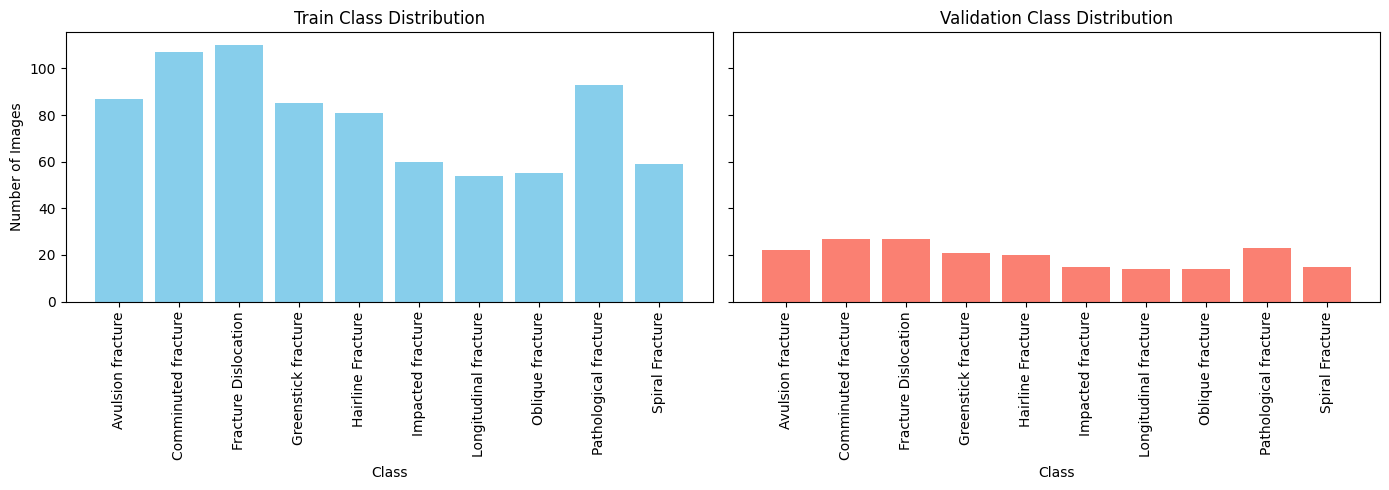

In [22]:
# Verify class balance

def count_subset_classes(subset):
    targets = [subset.dataset.labels[i] for i in subset.indices]
    return Counter(targets)

train_counts = count_subset_classes(train_subset)
val_counts = count_subset_classes(val_subset)

idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

# print("\nTrain class counts:")
# for idx, count in train_counts.items():
#     print(f"{idx_to_class[idx]}: {count}")

# print("\nVal class counts:")
# for idx, count in val_counts.items():
#     print(f"{idx_to_class[idx]}: {count}")

# Sort by class index
classes = [idx_to_class[i] for i in sorted(idx_to_class.keys())]
train_values = [train_counts.get(i, 0) for i in sorted(idx_to_class.keys())]
val_values = [val_counts.get(i, 0) for i in sorted(idx_to_class.keys())]

# --- Plot side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Train plot
axes[0].bar(classes, train_values, color='skyblue')
axes[0].set_title("Train Class Distribution")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Number of Images")
axes[0].tick_params(axis='x', rotation=90)

# Validation plot
axes[1].bar(classes, val_values, color='salmon')
axes[1].set_title("Validation Class Distribution")
axes[1].set_xlabel("Class")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
def output_to_label(z):
    return torch.argmax(z, dim=1)

def train_one_epoch(model, dataloader, optimizer, loss_fn, device, scaler=None):
    model.train()
    total_loss, total_acc = 0.0, 0.0

    loop = tqdm(dataloader, desc="Training", leave=False)
    for x, y in loop:
        x, y = x.to(device), y.to(device).long()
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=(scaler is not None)):
            outputs = model(x)
            loss = loss_fn(outputs, y)

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        acc = (preds == y).float().mean().item()

        total_loss += loss.item()
        total_acc += acc

        loop.set_postfix(loss=loss.item(), acc=acc)

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / len(dataloader)
    return avg_loss, avg_acc


def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_acc = 0.0, 0.0
    with torch.no_grad():
        loop = tqdm(dataloader, desc="Validation", leave=False)
        for x, y in loop:
            x, y = x.to(device), y.to(device).long()
            outputs = model(x)
            loss = loss_fn(outputs, y)
            preds = torch.argmax(outputs, dim=1)
            acc = (preds == y).float().mean().item()

            total_loss += loss.item()
            total_acc += acc

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / len(dataloader)
    return avg_loss, avg_acc


def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    print("Starting training...\n")

    for epoch in range(1, num_epochs + 1):
        print(f"Epoch {epoch}/{num_epochs}")

        # --- Gradual Unfreezing ---
        if epoch == 15:
            print("Unfreezing last 2 DeiT blocks...")
            for name, param in model.blocks[-3:].named_parameters():
                param.requires_grad = True
            for name, param in model.norm.named_parameters():
                param.requires_grad = True
            optimizer = optim.AdamW(model.parameters(), lr=5e-6,weight_decay=0.05)
        elif epoch == 30:
            print("Unfreezing last 6 DeiT blocks...")
            for name, param in model.blocks[-7:].named_parameters():
                param.requires_grad = True
            for name, param in model.norm.named_parameters():
                param.requires_grad = True

        # --- Train and Validate ---
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn, device, scaler)
        val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # --- Save best model ---
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Best model updated and saved.")

    print(f"\nTraining complete. Best validation accuracy: {best_val_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accs, val_losses, val_accs


In [34]:
model = timm.create_model('deit_base_patch16_224', pretrained=True)

model.head = nn.Linear(model.head.in_features, 10)

# Freeze all DeiT backbone parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the classification head
for param in model.head.parameters():
    param.requires_grad = True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

labels = train_dataset.labels
counts = Counter(labels)
total = sum(counts.values())
class_weights = torch.tensor([total / counts[i] for i in range(len(counts))], dtype=torch.float)
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))


lr = 8e-6
optimizer = optim.AdamW(model.parameters(), lr=8e-6,weight_decay=0.05)
num_epochs = 25
print_every = None

model, train_losses, train_accs, val_losses, val_accs = training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every)

C:\Users\toshi\AppData\Local\Temp\ipykernel_16748\723858819.py:62: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Starting training...

Epoch 1/25


Training:   0%|          | 0/25 [00:00<?, ?it/s]C:\Users\toshi\AppData\Local\Temp\ipykernel_16748\723858819.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Train Loss: 2.3353 | Train Acc: 0.0810 | Val Loss: 2.3435 | Val Acc: 0.0759
✅ Best model updated and saved.
Epoch 2/25


Train Loss: 2.3292 | Train Acc: 0.0847 | Val Loss: 2.3394 | Val Acc: 0.0759
Epoch 3/25


Train Loss: 2.3223 | Train Acc: 0.0815 | Val Loss: 2.3360 | Val Acc: 0.0625
Epoch 4/25


Train Loss: 2.3178 | Train Acc: 0.0835 | Val Loss: 2.3325 | Val Acc: 0.0714
Epoch 5/25


Train Loss: 2.3141 | Train Acc: 0.0882 | Val Loss: 2.3290 | Val Acc: 0.0714
Epoch 6/25


Train Loss: 2.3088 | Train Acc: 0.0885 | Val Loss: 2.3261 | Val Acc: 0.0670
Epoch 7/25


Train Loss: 2.3042 | Train Acc: 0.0970 | Val Loss: 2.3227 | Val Acc: 0.0670
Epoch 8/25


Train Loss: 2.3009 | Train Acc: 0.0963 | Val Loss: 2.3199 | Val Acc: 0.0714
Epoch 9/25


Train Loss: 2.2954 | Train Acc: 0.0990 | Val Loss: 2.3168 | Val Acc: 0.0625
Epoch 10/25


Train Loss: 2.2928 | Train Acc: 0.1035 | Val Loss: 2.3144 | Val Acc: 0.0580
Epoch 11/25


Train Loss: 2.2884 | Train Acc: 0.1037 | Val Loss: 2.3116 | Val Acc: 0.0580
Epoch 12/25


Train Loss: 2.2840 | Train Acc: 0.1124 | Val Loss: 2.3090 | Val Acc: 0.0625
Epoch 13/25


Train Loss: 2.2798 | Train Acc: 0.1085 | Val Loss: 2.3063 | Val Acc: 0.0714
Epoch 14/25


Validation:  71%|███████▏  | 5/7 [00:08<00:03,  1.69s/it]                       